In [1]:
import pandas as pd

df = pd.read_csv('../../data/preprocessed_train.csv')
df = df[['data', 'label']]

df.head()

,data,label
0,지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...,0
1,길동경찰서입니다 . 시 분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 한번만...,0
2,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...,3
3,어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ...,1
4,저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 이 선크림 파는데 한 번 손등에...,1


In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf


tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']


def data_load(num_words=20000):
    
    X = df['data']
    Y = tf.keras.utils.to_categorical(df['label'], num_classes=4, dtype='float32')
    
    x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)
    
    def tokenize(data):
        result = []
        for sentence in data:
            temp = tokenizer.morphs(sentence)
            temp = [word for word in temp if not word in stopwords] 
            result.append(temp)
        return result
   
    X_train = tokenize(x_train)
    X_test = tokenize(x_test)
    X_val = tokenize(x_val)
                                                         
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = { word:index for index, word in enumerate(vocab) }
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    X_val = list(map(wordlist_to_indexlist, X_val))
                                                                                                             
    return X_train, y_train, X_test, y_test, X_val, y_val, word_to_index

x_train, y_train, x_test, y_test, x_val, y_val, word_to_index = data_load()
index_to_word = { index: word for word, index in word_to_index.items() }

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=70)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=70)

x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val,
                                                      value=word_to_index["<PAD>"],
                                                      padding='pre',
                                                      maxlen=70)

vocab_size = len(word_to_index)
word_vector_dim = 128

In [3]:
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, GlobalMaxPooling1D, Conv1D, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score
# from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)


class ClassifierModel():
    def __init__(self, cnn=False, bi_lstm=False, lstm=False):
        super(ClassifierModel, self).__init__()
        
        self.cnn = cnn
        self.bi_lstm = bi_lstm
        self.lstm = lstm
        
        self.title = self.set_title()
        
        self.model = self.set_model()
        self.history = None
        self.es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
            
    def set_title(self):
        title = ''
        if self.cnn:
            title += 'CNN'
        
        if self.bi_lstm:
            if title != '':
                title += '_'
            title += 'BiLSTM'
        
        if self.lstm:
            if title != '':
                title += '_'
            title += 'LSTM'
        return title
    
            
    def set_model(self):
        
        model = Sequential(name=self.title)
        model.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
                
        if self.cnn:
            model.add(Conv1D(64, 3, activation='relu'))
            model.add(Dropout(0.5))
            
        if self.bi_lstm:
            forward_layer = LSTM(64, return_sequences=True)
            backward_layer = LSTM(64, activation='relu', return_sequences=True, go_backwards=True)
            model.add(Bidirectional(forward_layer, backward_layer=backward_layer))
            if not self.lstm:
                model.add(Dropout(0.1))
        
        if self.lstm:
            model.add(LSTM(64, return_sequences=True))
            
        model.add(GlobalMaxPooling1D())
        
        if self.lstm:
            model.add(Dropout(0.5))
            
        model.add(Dense(4, activation='softmax'))
        
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        return model
        
    
    def summary(self):
        return self.model.summary()
    
    
    def train(self, x, y, x_val, y_val):
        self.history = self.model.fit(
            x, y, epochs=20, batch_size=64,
            validation_data=(x_val, y_val), callbacks=self.es, verbose=1)
    
    def evaluate(self, x, y):
        return self.model.evaluate(x, y, verbose=2)
    
    
    def show_history(self):
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy'])
        plt.title(f'{self.title} accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title(f'{self.title} loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        
    
    def show_report(self, x, y):
        y_pred = self.model.predict(x).argmax(axis=1)
        y_true = y.argmax(axis=1)
        
#         print(f'accuracy : {accuracy_score(y_true, y_pred)}')
#         print(f'precision : {precision_score(y_true, y_pred)}')
#         print(f'recall : {recall_score(y_true, y_pred)}')
#         print(f'f1 : {f1_score(y_true, y_pred)}')
        
        conf_matrix = confusion_matrix(y_true, y_pred)
        names = ["협박", "갈취", "직장내 괴롭힘", "기타 괴롭힘"]
        conf_matrix = pd.DataFrame(conf_matrix, index=names, columns=names)
        sns.heatmap(conf_matrix, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.show()

# 1. CNN

In [4]:
cnn = ClassifierModel(cnn=True, bi_lstm=False, lstm=False)
cnn.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          24640     
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 260       
Total params: 1,304,900
Trainable params: 1,304,900
Non-trainable params: 0
_________________________________________________________________


In [5]:
cnn.train(x_train, y_train, x_val, y_val)

Epoch 1/20
40/40 [==============================] - 4s 16ms/step - loss: 1.3108 - accuracy: 0.4506 - val_loss: 1.2649 - val_accuracy: 0.6354
Epoch 2/20
40/40 [==============================] - 0s 5ms/step - loss: 1.0142 - accuracy: 0.7275 - val_loss: 1.0089 - val_accuracy: 0.7025
Epoch 3/20
40/40 [==============================] - 0s 5ms/step - loss: 0.7063 - accuracy: 0.7690 - val_loss: 0.8059 - val_accuracy: 0.7519
Epoch 4/20
40/40 [==============================] - 0s 5ms/step - loss: 0.4999 - accuracy: 0.8350 - val_loss: 0.6840 - val_accuracy: 0.7772
Epoch 5/20
40/40 [==============================] - 0s 4ms/step - loss: 0.3686 - accuracy: 0.8873 - val_loss: 0.6203 - val_accuracy: 0.7962
Epoch 6/20
40/40 [==============================] - 0s 5ms/step - loss: 0.2601 - accuracy: 0.9331 - val_loss: 0.5749 - val_accuracy: 0.8127
Epoch 7/20
40/40 [==============================] - 0s 4ms/step - loss: 0.1821 - accuracy: 0.9589 - val_loss: 0.5484 - val_accuracy: 0.8165
Epoch 8/20
40/40 [=

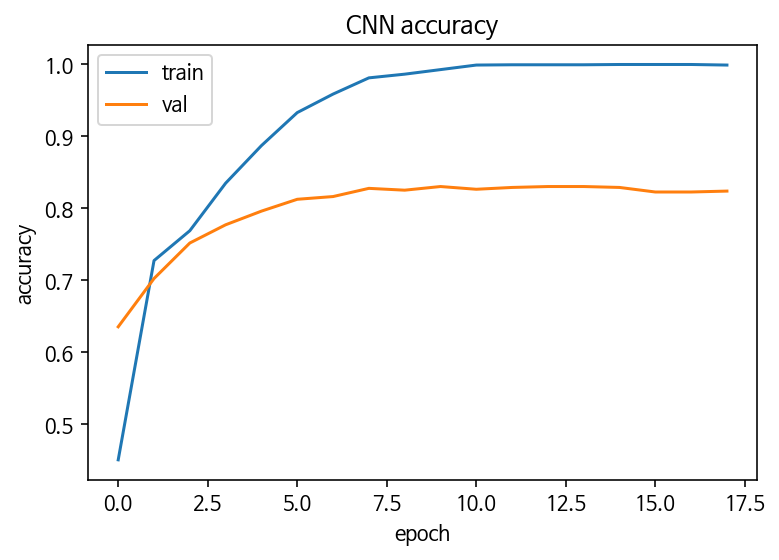

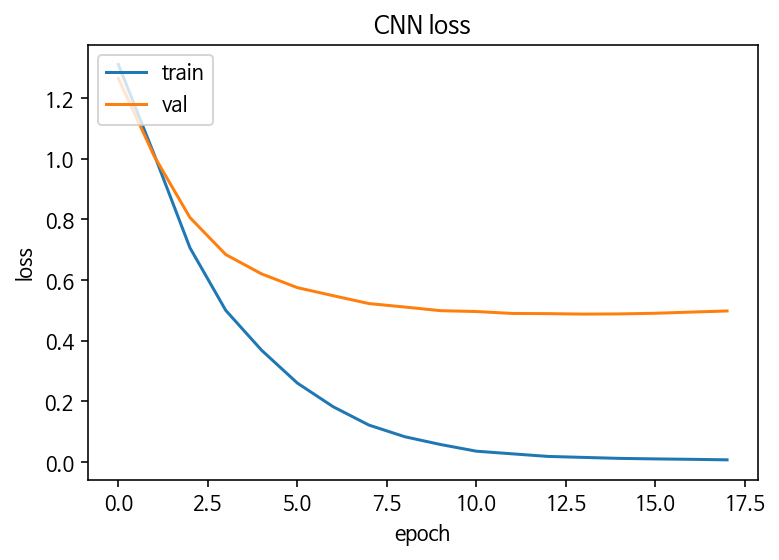

In [6]:
cnn.show_history()

In [7]:
cnn.evaluate(x_test, y_test)

20/20 - 0s - loss: 0.4975 - accuracy: 0.8212


[0.49746939539909363, 0.8212025165557861]

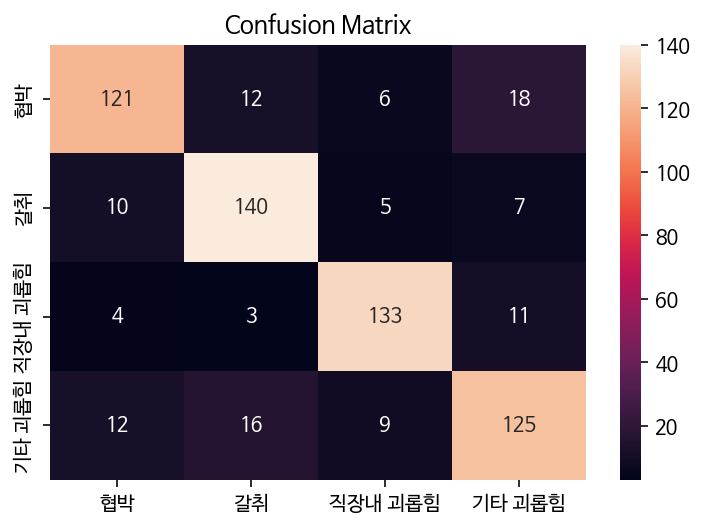

In [8]:
cnn.show_report(x_test, y_test)

# BiLSTM

In [9]:
bilstm = ClassifierModel(cnn=False, bi_lstm=True, lstm=False)
bilstm.summary()

Model: "BiLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 1,379,332
Trainable params: 1,379,332
Non-trainable params: 0
_________________________________________________________________


In [10]:
bilstm.train(x_train, y_train, x_val, y_val)

Epoch 1/20
40/40 [==============================] - 9s 151ms/step - loss: 1.3333 - accuracy: 0.3995 - val_loss: 1.1829 - val_accuracy: 0.4177
Epoch 2/20
40/40 [==============================] - 6s 141ms/step - loss: 17952.0410 - accuracy: 0.6286 - val_loss: 842.5734 - val_accuracy: 0.6734
Epoch 3/20
40/40 [==============================] - 5s 137ms/step - loss: 1.6849 - accuracy: 0.7836 - val_loss: 0.7451 - val_accuracy: 0.7203
Epoch 4/20
40/40 [==============================] - 6s 140ms/step - loss: 0.3934 - accuracy: 0.8916 - val_loss: 0.7429 - val_accuracy: 0.7544
Epoch 5/20
40/40 [==============================] - 6s 141ms/step - loss: 0.2310 - accuracy: 0.9466 - val_loss: 0.7663 - val_accuracy: 0.7278
Epoch 6/20
40/40 [==============================] - 6s 139ms/step - loss: 0.1585 - accuracy: 0.9636 - val_loss: 0.8375 - val_accuracy: 0.7443
Epoch 7/20
40/40 [==============================] - 6s 139ms/step - loss: 0.1210 - accuracy: 0.9695 - val_loss: 0.8652 - val_accuracy: 0.7468


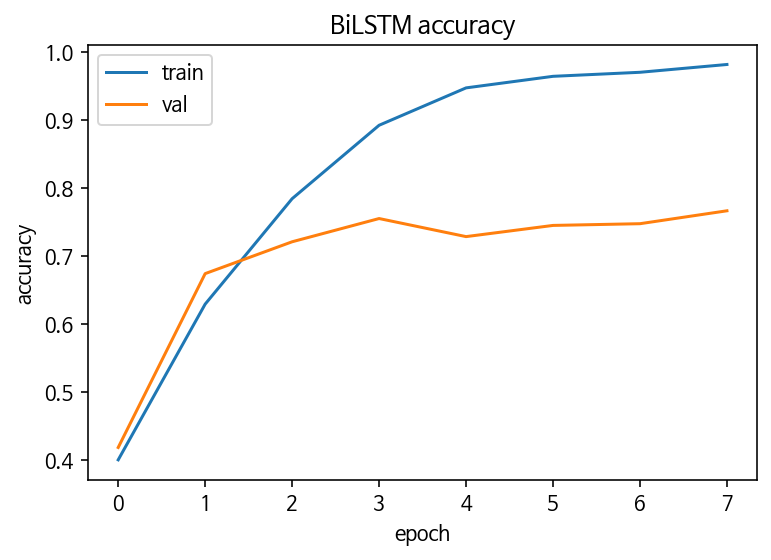

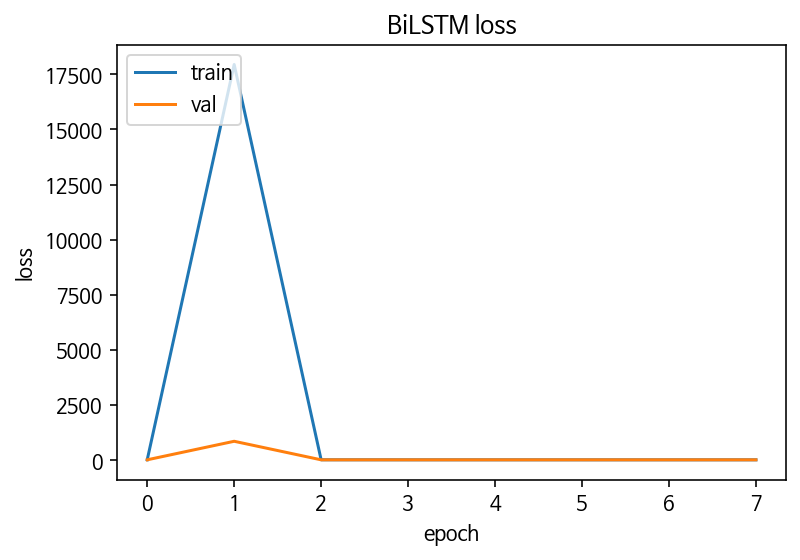

In [11]:
bilstm.show_history()

In [12]:
bilstm.evaluate(x_test, y_test)

20/20 - 0s - loss: 0.7638 - accuracy: 0.7627


[0.7637858986854553, 0.7626582384109497]

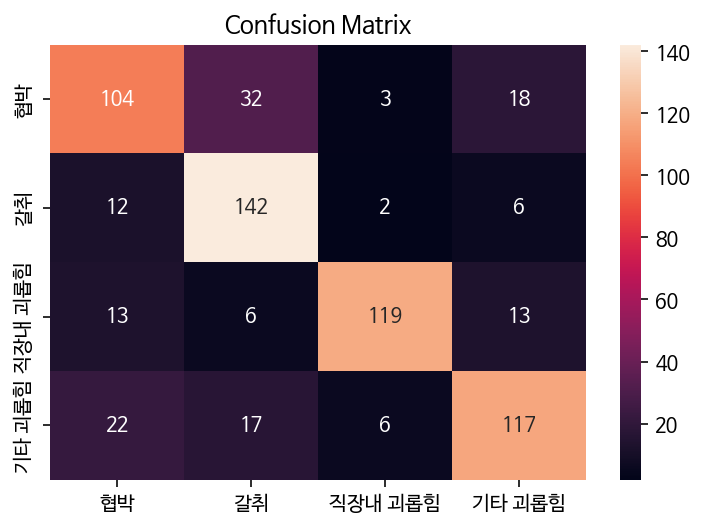

In [13]:
bilstm.show_report(x_test, y_test)

# 2. BiLSTM + LSTM

In [14]:
bilstm_lstm = ClassifierModel(cnn=False, bi_lstm=True, lstm=True)
bilstm_lstm.summary()

Model: "BiLSTM_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 1,428,484
Trainable params: 1,428,484
Non-trainable params: 0
_____________________________________________

In [15]:
bilstm_lstm.train(x_train, y_train, x_val, y_val)

Epoch 1/20
40/40 [==============================] - 9s 155ms/step - loss: 1.3458 - accuracy: 0.3513 - val_loss: 1.1920 - val_accuracy: 0.4380
Epoch 2/20
40/40 [==============================] - 6s 142ms/step - loss: 0.8879 - accuracy: 0.6760 - val_loss: 0.6684 - val_accuracy: 0.7873
Epoch 3/20
40/40 [==============================] - 6s 142ms/step - loss: 0.4203 - accuracy: 0.8770 - val_loss: 0.7204 - val_accuracy: 0.7734
Epoch 4/20
40/40 [==============================] - 6s 141ms/step - loss: 0.2363 - accuracy: 0.9422 - val_loss: 0.6477 - val_accuracy: 0.8013
Epoch 5/20
40/40 [==============================] - 6s 148ms/step - loss: 0.1165 - accuracy: 0.9739 - val_loss: 0.8201 - val_accuracy: 0.7911
Epoch 6/20
40/40 [==============================] - 6s 139ms/step - loss: 0.0834 - accuracy: 0.9850 - val_loss: 0.8159 - val_accuracy: 0.7924
Epoch 7/20
40/40 [==============================] - 6s 143ms/step - loss: 0.1218 - accuracy: 0.9731 - val_loss: 0.7489 - val_accuracy: 0.7886
Epoch 

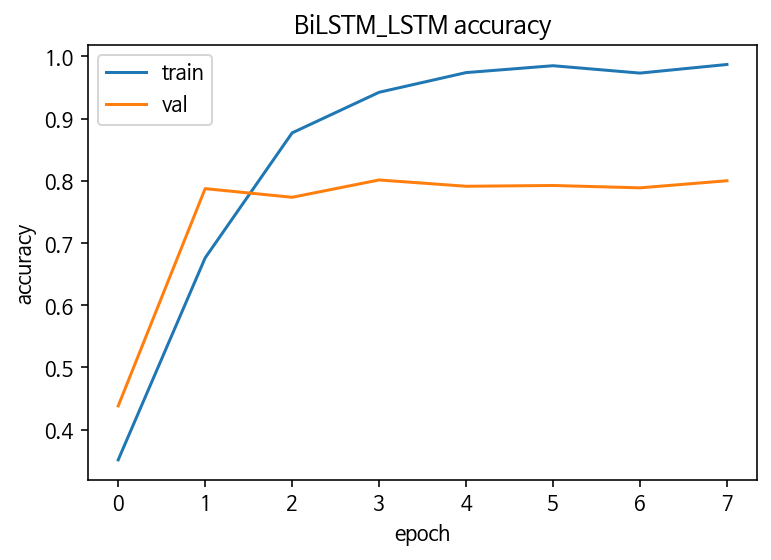

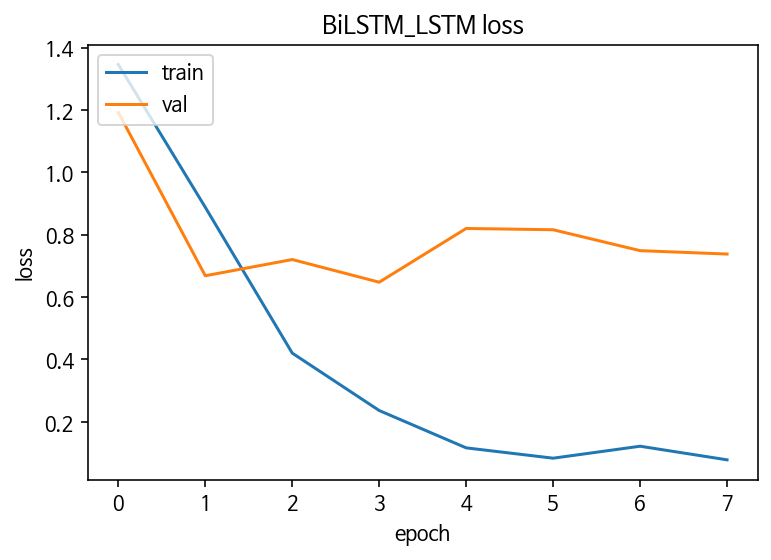

In [16]:
bilstm_lstm.show_history()

In [17]:
bilstm_lstm.evaluate(x_test, y_test)

20/20 - 0s - loss: 0.6237 - accuracy: 0.8291


[0.6236830353736877, 0.8291139006614685]

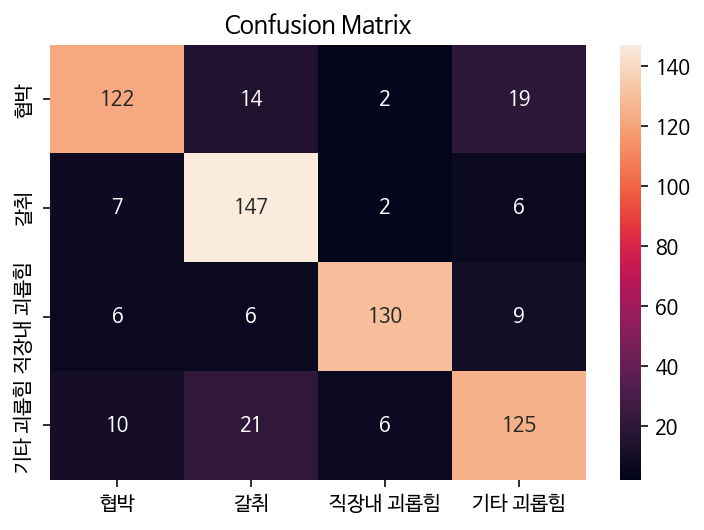

In [18]:
bilstm_lstm.show_report(x_test, y_test)

# CNN + BiLSTM + LSTM

In [19]:
cnn_bilstm_lstm = ClassifierModel(cnn=True, bi_lstm=True, lstm=True)
cnn_bilstm_lstm.summary()

Model: "CNN_BiLSTM_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          24640     
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)            

In [20]:
cnn_bilstm_lstm.train(x_train, y_train, x_val, y_val)

Epoch 1/20
40/40 [==============================] - 9s 150ms/step - loss: 1.3831 - accuracy: 0.2781 - val_loss: 1.3717 - val_accuracy: 0.2722
Epoch 2/20
40/40 [==============================] - 5s 129ms/step - loss: 1.1979 - accuracy: 0.4462 - val_loss: 0.8953 - val_accuracy: 0.6038
Epoch 3/20
40/40 [==============================] - 5s 129ms/step - loss: 0.7246 - accuracy: 0.6950 - val_loss: 0.7032 - val_accuracy: 0.7304
Epoch 4/20
40/40 [==============================] - 5s 131ms/step - loss: 0.4459 - accuracy: 0.8457 - val_loss: 0.6902 - val_accuracy: 0.7570
Epoch 5/20
40/40 [==============================] - 5s 128ms/step - loss: 0.2569 - accuracy: 0.9193 - val_loss: 0.6899 - val_accuracy: 0.7835
Epoch 6/20
40/40 [==============================] - 5s 131ms/step - loss: 0.1512 - accuracy: 0.9604 - val_loss: 0.7389 - val_accuracy: 0.7861
Epoch 7/20
40/40 [==============================] - 5s 126ms/step - loss: 0.1357 - accuracy: 0.9672 - val_loss: 0.7983 - val_accuracy: 0.7696
Epoch 

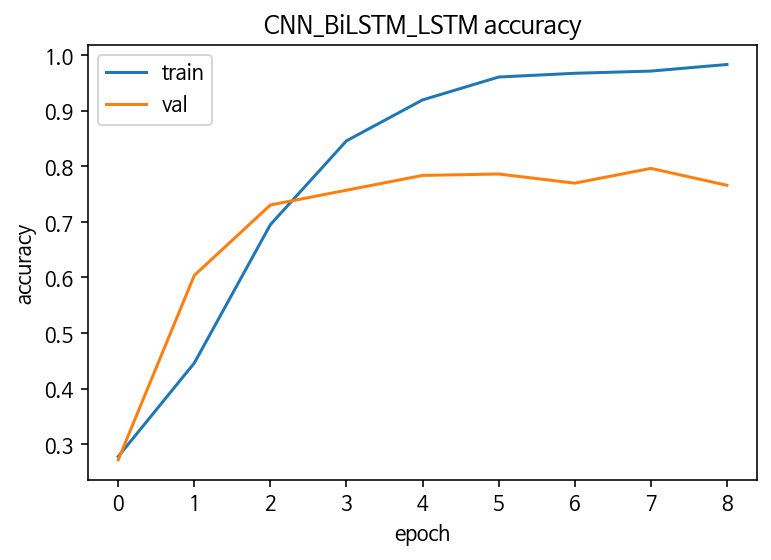

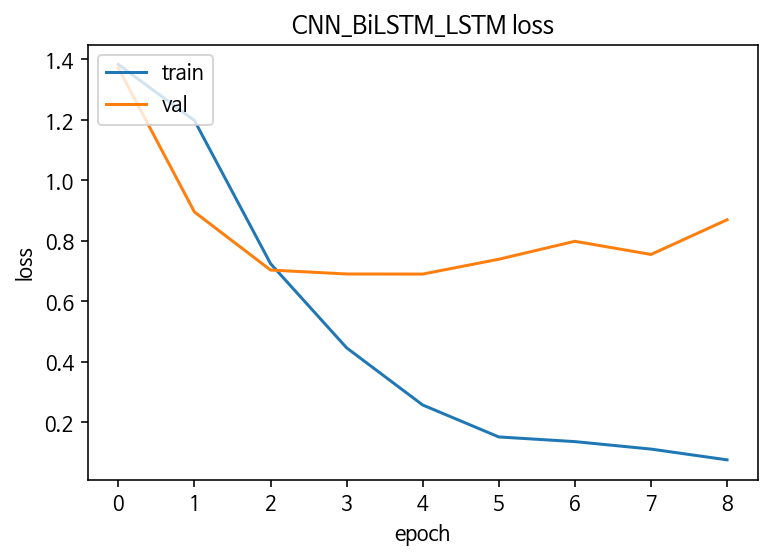

In [21]:
cnn_bilstm_lstm.show_history()

In [22]:
cnn_bilstm_lstm.evaluate(x_test, y_test)

20/20 - 0s - loss: 0.6968 - accuracy: 0.8038


[0.6967670321464539, 0.8037974834442139]

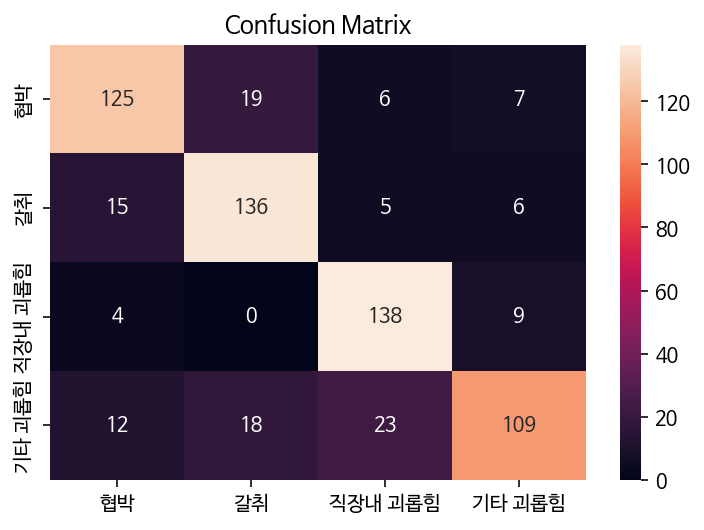

In [23]:
cnn_bilstm_lstm.show_report(x_test, y_test)

|모델|Loss|Accuracy|
|:---:|---|:---:|
|CNN|0.4975|0.8212|
|BiLSTM|0.7638|0.7627|
|BiLSTM + LSTM|0.6237|0.8291|
|CNN + BiLSTM + LSTM|0.6968|0.8038|